Clean data first!

In [9]:
import numpy as np
from matplotlib import pyplot as plt
import xgboost as xgb

#elements = np.load('post_process/poscar_elements_list.txt')
#eig_values = np.loadtxt('post_process/eigenvalues_list.txt')

In [10]:
import numpy as np
import pandas as pd

# Define the maximum number of elements for the vacancy calculation
max_elements = 432

# Function to convert element strings into distributions
def parse_element_string(elem_str, total_elements=max_elements):
    # Dictionary of elements
    element_counts = {"H": 0, "B": 0, "C": 0, "N": 0, "O": 0, "Al": 0, "Si": 0, "P": 0, "Ga": 0, "As": 0}
    
    # Parse element counts using regex
    import re
    matches = re.findall(r"([A-Z][a-z]*)(\d*)", elem_str)
    
    total_atoms = 0
    for match in matches:
        element, count = match
        count = int(count) if count else 1
        total_atoms += count
        if element in element_counts:
            element_counts[element] += count

    # Calculate the number of vacancies
    element_counts["Vacancy"] = total_elements - total_atoms

    # Normalize to get probabilities
    distribution = {key: value / total_elements for key, value in element_counts.items()}
    distribution['Element_string'] = elem_str[:-1]
    
    return distribution

element_distributions = []
with open('post_process/poscar_elements_list.txt', 'r') as f:
    for line in f:
        element_distributions.append(parse_element_string(line))
'''
# Process all element strings and create a DataFrame
element_distributions = [parse_element_string(elem) for elem in poscar_elements]'''

# Convert to DataFrame for visualization
element_df = pd.DataFrame(element_distributions)
#element_df.insert(0, 'Element_String', poscar_elements)

element_df.head(5)


,H,B,C,N,O,Al,Si,P,Ga,As,Vacancy,Element_string
0,0.018519,0.000000,0.0,0.0,0.0,0.0,0.942130,0.025463,0.0,0.0,0.013889,H8P11Si407
1,0.023148,0.000000,0.0,0.0,0.0,0.0,0.942130,0.020833,0.0,0.0,0.013889,H10P9Si407
2,0.023148,0.000000,0.0,0.0,0.0,0.0,0.942130,0.020833,0.0,0.0,0.013889,H10P9Si407
3,0.018519,0.000000,0.0,0.0,0.0,0.0,0.942130,0.025463,0.0,0.0,0.013889,H8P11Si407
4,0.000000,0.039352,0.0,0.0,0.0,0.0,0.951389,0.000000,0.0,0.0,0.009259,B17Si411


In [11]:
df = element_df.drop(columns=['Si', 'Element_string'], axis=1)

residual_elements = np.array([row.values for _, row in df.iterrows()])

residual_elements.shape, residual_elements[2]

((468, 10),
 array([0.02314815, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.02083333, 0.        , 0.        , 0.01388889]))

Proper fine + coarse grid for DoS

In [12]:
fine_bins = np.linspace(0, 0.05, num=50)  # 50 bins between 0 and 0.05 for fine sampling
coarse_bins = np.linspace(0.051, 0.251, num=10)  # 10 bins for coarser sampling

# Combine the fine and coarse bins, ensuring no duplicate at 0.05
total_bins = np.concatenate((fine_bins, coarse_bins))
len(total_bins)

60

In [13]:
eigvals_pristine = []

with open('post_process/pristine_eigenvalues.txt', 'r') as f:
    for line in f:
        eigvals_pristine.append(np.real(eval(line)))

Dos_pristine, _ = np.histogram(eigvals_pristine, bins=total_bins, density=True)
Dos_pristine = np.array(Dos_pristine)
Dos_pristine.shape

(59,)

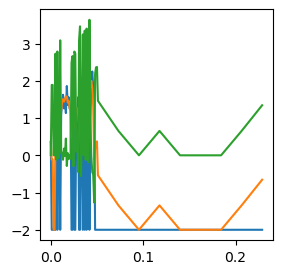

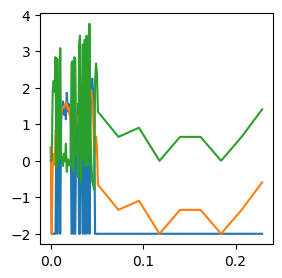

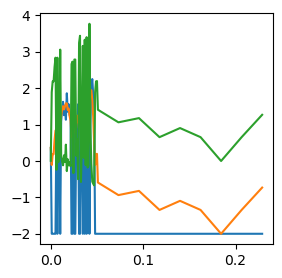

In [14]:
Dos_with_defect = []

with open('post_process/eigenvalues_list.txt', 'r') as file:
    for line in file:
        eigenvalues = [float(value) for value in line.split()]
        counts, _ = np.histogram(eigenvalues, bins=total_bins, density=True)
        Dos_with_defect.append(counts)

Dos_with_defect = np.array(Dos_with_defect)
Dos_with_defect.shape
N = len(Dos_with_defect)

# this is the data
residual_dos = np.log10(Dos_with_defect + 1e-2) - np.log10(Dos_pristine + 1e-2)

for i in range(3):
    plt.figure(figsize=(3, 3))
    plt.plot(total_bins[:-1], np.log10(Dos_pristine + 1e-2))
    plt.plot(total_bins[:-1], np.log10(Dos_with_defect[i] + 1e-2))
    #Dos_with_defect[i] -= Dos_pristine
    plt.plot(total_bins[:-1], residual_dos[i])
    plt.show()

Now, time to construct a machine learning model
Columns: [H, B, C, No, O, Al, P, Ga, As, Vac]

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
# input: residual_dos
# output: residual_elements
residual_dos.shape, residual_elements.shape

((468, 59), (468, 10))

In [16]:
# Assuming residual_dos and residual_elements are your datasets
# Example shapes: residual_dos.shape == (468, 59), residual_elements.shape == (468, 10)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(residual_dos, residual_elements, test_size=0.2, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to XGBoost DMatrix for better handling (optional but recommended)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Parameters for XGBoost
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "learning_rate": 0.1,
    "max_depth": 6,
    "n_estimators": 50,
    #"early_stopping_rounds": 5
}

# Watchlist for logging
eval_set = [(X_train, y_train), (X_test, y_test)]

# Train the model
model = xgb.XGBRegressor(**params)

print("Starting training...")
model.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    verbose=True,  # This enables iteration-wise logging
)

# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on Test Set: {mse}")


Starting training...
[0]	validation_0-rmse:0.00664	validation_1-rmse:0.00663
[1]	validation_0-rmse:0.00605	validation_1-rmse:0.00615
[2]	validation_0-rmse:0.00552	validation_1-rmse:0.00575
[3]	validation_0-rmse:0.00504	validation_1-rmse:0.00540
[4]	validation_0-rmse:0.00461	validation_1-rmse:0.00509
[5]	validation_0-rmse:0.00422	validation_1-rmse:0.00484
[6]	validation_0-rmse:0.00386	validation_1-rmse:0.00461
[7]	validation_0-rmse:0.00354	validation_1-rmse:0.00440
[8]	validation_0-rmse:0.00324	validation_1-rmse:0.00423
[9]	validation_0-rmse:0.00298	validation_1-rmse:0.00409
[10]	validation_0-rmse:0.00274	validation_1-rmse:0.00398
[11]	validation_0-rmse:0.00251	validation_1-rmse:0.00388
[12]	validation_0-rmse:0.00232	validation_1-rmse:0.00379
[13]	validation_0-rmse:0.00214	validation_1-rmse:0.00372
[14]	validation_0-rmse:0.00197	validation_1-rmse:0.00366
[15]	validation_0-rmse:0.00182	validation_1-rmse:0.00362
[16]	validation_0-rmse:0.00169	validation_1-rmse:0.00358
[17]	validation_0-rm

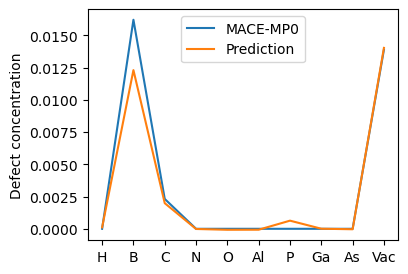

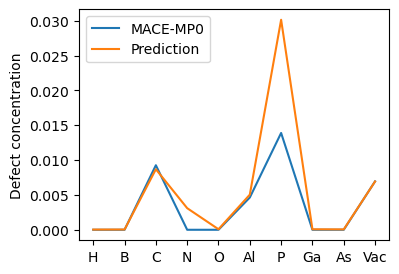

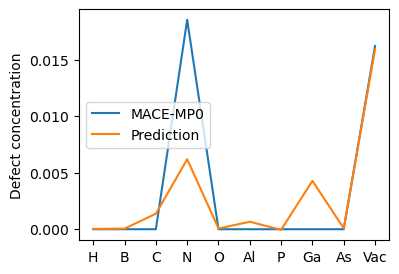

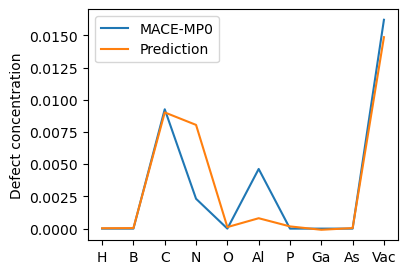

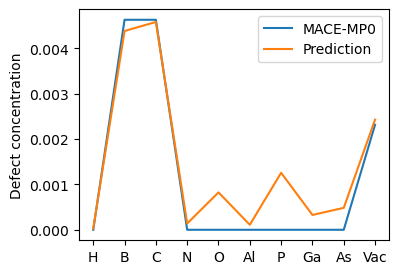

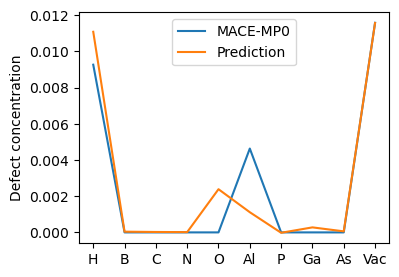

In [ ]:
for i in range(6):
    plt.figure(figsize=(4, 3))
    plt.plot(range(10), y_test[i], label='MACE-MP0')
    plt.plot(range(10), y_pred[i], label='Prediction')
    plt.xticks(range(10), ['H', 'B', 'C', 'N', 'O', 'Al', 'P', 'Ga', 'As', 'Vac'])
    plt.ylabel('Defect concentration')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'assets/Pred_{i}.pdf')
    plt.show()